In [2]:
using CSV, DataFrames
using CairoMakie

### Parameter Dependency

In [3]:
region = "california"
magnitude_threshold = 0.0

results = CSV.read("./results/$region/$(region)_minmag_$(magnitude_threshold)_alpha_xmin_dependency_cell_size.csv", DataFrame)
first(results,5)

Row,cell_size,alpha,xmin,KS
,Float64,Float64,Float64,Float64
1,0.5,3.33504,46.0,0.0244906
2,1.0,3.03866,108.0,0.0225605
3,1.5,2.93319,238.0,0.0276943
4,2.0,2.50847,156.0,0.027515
5,2.5,3.47107,1272.0,0.0275452


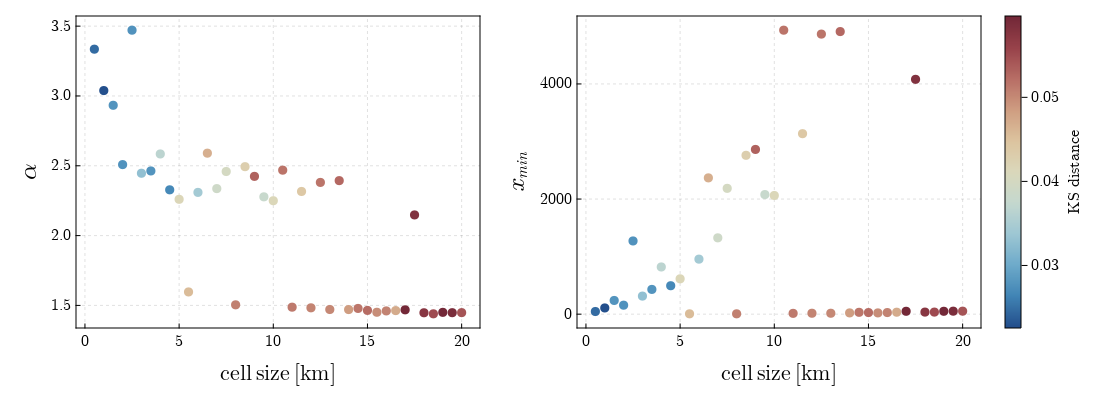

In [20]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (1100, 400), font= "CMU Serif") ## probably you need to install this font in your system
xlabels = [L"\text{cell\,size\,[km]}", L"\text{cell\,size\,[km]}"]
ylabels = [L"\alpha", L"x_{min}"]
ax = [Axis(fig[1, i], xlabel = xlabels[i], ylabel = ylabels[i], ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10) for i in 1:2]
scatter!(ax[1],results.cell_size, results.alpha; color = results.KS, colormap = reverse(cgrad(:redblue)),
    markersize = 13, marker = :circle, strokewidth = 0)
xmin_scat = scatter!(ax[2],results.cell_size, results.xmin; color = results.KS, colormap = reverse(cgrad(:redblue)),
    markersize = 13, marker = :circle, strokewidth = 0)
cbar = Colorbar(fig[1,3], xmin_scat, label="KS distance")

# axislegend(L"f(x)"; position = :rt, bgcolor = (:grey90, 0.25));

# save("test.png", fig, px_per_unit=5)

fig

## Best fits

In [24]:
using CSV, DataFrames
using FileIO, Dates
using DataStructures
using PyCall
# using Plots
# using PyPlot; gr()
# using HypothesisTests

using CairoMakie
include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw

In [22]:
region = "romania"
cell_size = 5.0

# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
magnitude_threshold = 0.0

0.0

In [25]:
df, df_cubes = region_cube_split(df,cell_size=cell_size)
MG = create_network(df, df_cubes)
degrees=[]
for i in 1:nv(MG)
    push!(degrees, get_prop(MG, i, :degree))
end

# Powerlaw Fit
fit = powlaw.Fit(degrees);
alpha = round(fit.alpha, digits=4)
xmin = round(fit.xmin, digits=4)
KS = round(fit.power_law.KS(data=degrees), digits=4)

Calculating best minimal value for power law fit
C:\Users\gabipana\.julia\conda\3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


0.0385

In [27]:
# CCDF of truncated data (fitted), x and y values
x_ccdf, y_ccdf = fit.ccdf()

# The fit (from theoretical power_law)
fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

########################################### ALL
# CCDF of all data scattered 
x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)

(Int32[2, 4, 6, 7, 8, 10, 12, 14, 16, 18  …  174, 182, 186, 266, 284, 302, 308, 352, 392, 446], [1.0, 0.39952763344355224, 0.2455361360415682, 0.17213037316957958, 0.17203589985829004, 0.13169579593764758, 0.1030703826169107, 0.08549834671705248, 0.07208313651393483, 0.061407652338214436  …  0.0009447331128955572, 0.0008502598016060237, 0.0007557864903164901, 0.0006613131790269566, 0.0005668398677373121, 0.0004723665564477786, 0.00037789324515824507, 0.00028341993386871156, 0.00018894662257906703, 9.447331128953351e-5])

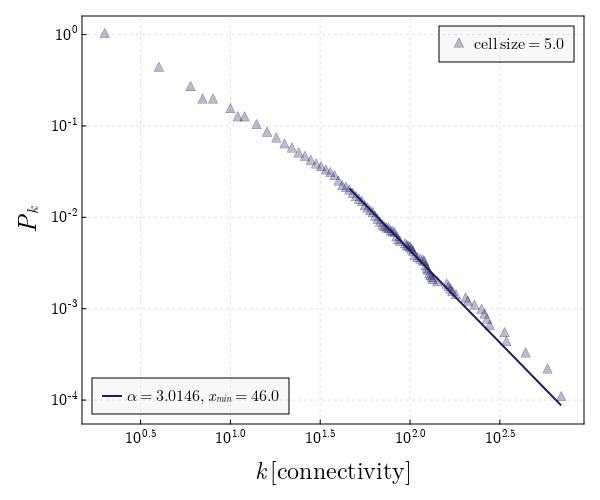

In [119]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (600, 500)) ## probably you need to install this font in your system

ax = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 24, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

sc = scatter!(x_ccdf_original_data, y_ccdf_original_data, 
    color=(:midnightblue, 0.3), strokewidth=0.2, marker=:utriangle, markersize=13)

ln = lines!(x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, 
    color=:midnightblue, linewidth=2) 

axislegend(ax,[sc], [L"\text{cell\,size}=%$(cell_size)"], position = :rt, bgcolor = (:grey90, 0.25));
axislegend(ax,[ln], [L"\alpha=%$(alpha),\, x_{min}=%$(xmin)"], position = :lb, bgcolor = (:grey90, 0.25));

fig

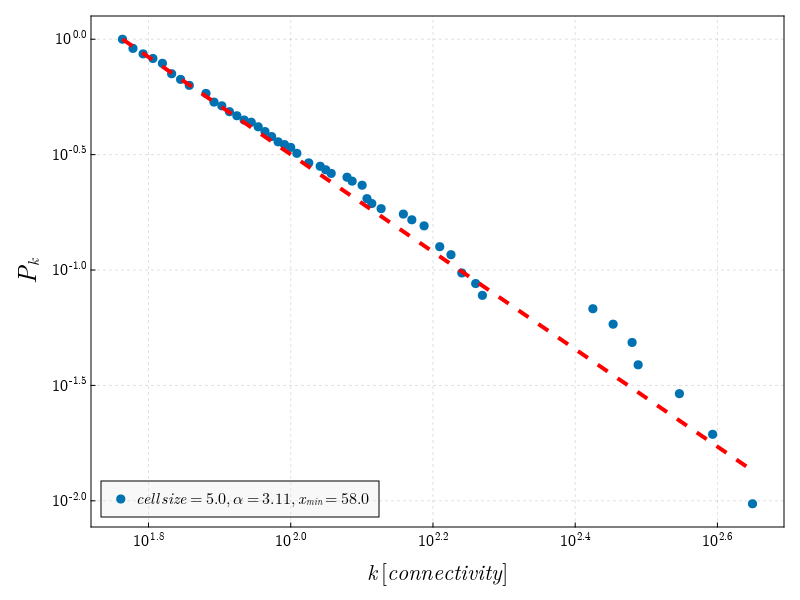

In [77]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (800, 600), font= "CMU Serif") ## probably you need to install this font in your system

ax = Axis(fig[1, 1], xlabel = L"k\,[connectivity]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

scatter!(x_ccdf, y_ccdf, label=L"cell\,size=%$(cell_size),\, \alpha=%$(alpha),\, x_{min}=%$(xmin)", 
    marker=:circle, markersize=13)

lines!(x_powlaw, y_powlaw, color=:red, linestyle=:dash, linewidth=4) 

axislegend(position = :lb, bgcolor = (:grey90, 0.25));

fig

In [82]:
if region == "romania"
    # cell_sizes = [3.5, 4.0, 4.5, 5.0, 5.5];
    cell_sizes = [3.5,  4.5,  5.5];
    # minimum_magnitudes = [0,1,2,3];
elseif region == "california"
    cell_sizes = [1.0, 1.5, 2.0];
    # minimum_magnitudes = [2,3];
elseif region == "italy"
    cell_sizes = [4.0, 4.5, 5.0, 5.5, 6.0];
    # minimum_magnitudes = [2,3];
elseif region == "japan"
    cell_sizes = [2.5, 3.0, 3.5, 4.0, 5.0];
    # minimum_magnitudes = [2,3,4,5];
end;

In [133]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig1 = Figure(resolution = (600, 500), font= "CMU Serif") ## probably you need to install this font in your system

ax1 = Axis(fig1[1, 1], xlabel = L"k\,[connectivity]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

fig2 = Figure(resolution = (600, 500), font= "CMU Serif") ## probably you need to install this font in your system

ax2 = Axis(fig2[1, 1], xlabel = L"k\,[connectivity]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

markers=[:utriangle, :diamond, :star5]
colors=[:midnightblue, :green, :darkred]

for i in eachindex(cell_sizes)
    df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
    MG = create_network(df, df_cubes)
    degrees=[]
    for i in 1:nv(MG)
        push!(degrees, get_prop(MG, i, :degree))
    end

    # Powerlaw Fit
    fit = powlaw.Fit(degrees);
    alpha = round(fit.alpha, digits=4)
    xmin = round(fit.xmin, digits=4)
    KS = round(fit.power_law.KS(data=degrees), digits=4)

    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    ########################################### ALL
    # CCDF of all data scattered 
    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)


    sc = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data, label=L"\text{cell\,size}=%$(cell_sizes[i])",
        color=(colors[i], 0.3), strokewidth=0.2, marker=markers[i], markersize=13)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln = lines!(ax1, x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)",
        color=colors[i], linewidth=2) 


    ########################################### TRUNCATED
    # CCDF of truncated data (fitted), the plot, (re-normed)
    sc = scatter!(ax2, x_ccdf, y_ccdf, label=L"\text{cell\,size}=%$(cell_sizes[i])",
        color=(colors[i], 0.3), strokewidth=0.2, marker=markers[i], markersize=13)

    # Fit through truncated data (re-normed)
    ln = lines!(ax2, x_powlaw, y_powlaw, label= L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)",
         color=colors[i], linewidth=2) 

end

axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25));
axislegend(ax2, position = :lb, bgcolor = (:grey90, 0.25));


# axislegend(ax1,[sc], [L"\text{cell\,size}=%$(cell_size)"], position = :rt, bgcolor = (:grey90, 0.25));
# axislegend(ax1,[ln], [L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)"], position = :lb, bgcolor = (:grey90, 0.25));
# save("test.png", fig, px_per_unit=5)

# axislegend(ax2,[sc], [L"\text{cell\,size}=%$(cell_size)"], position = :rt, bgcolor = (:grey90, 0.25));
# axislegend(ax2,[ln], [L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)"], position = :lb, bgcolor = (:grey90, 0.25));
# save("test.png", fig, px_per_unit=5)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Legend()

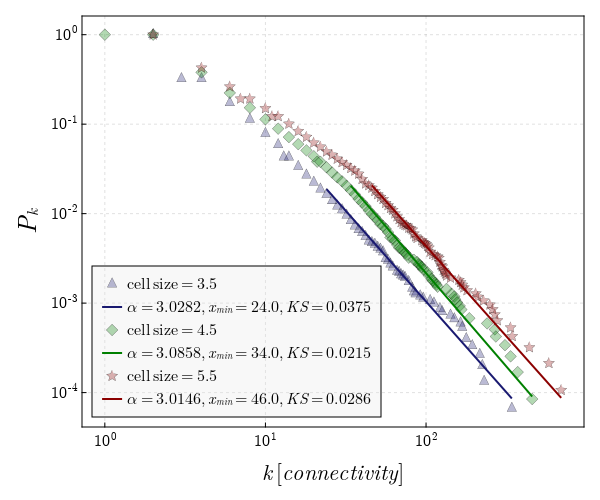

In [134]:
fig1

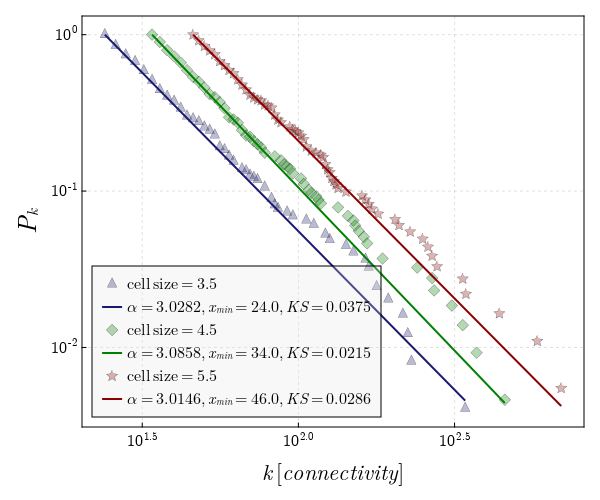

In [135]:
fig2

In [ ]:


Plots.scatter!(p1, x_ccdf_original_data, y_ccdf_original_data, xscale=:log10, yscale=:log10, 
                label="cell_size=$cell_size, alpha=$alpha, xmin=$xmin", markersize=3, alpha=0.8)
# Fit through truncated data
# Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
Plots.plot!(p1, x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, xscale=:log10, yscale=:log10, 
                label="", color=:red, linestyle=:dash, linewidth=3) 


########################################### TRUNCATED
# CCDF of truncated data (fitted), the plot, (re-normed)
Plots.scatter!(p2, x_ccdf, y_ccdf, xscale=:log10, yscale=:log10, label="cell_size=$cell_size, alpha=$alpha, xmin=$xmin", markersize=3, alpha=0.8)

# Fit through truncated data (re-normed)
Plots.plot!(p2, x_powlaw, y_powlaw, xscale=:log10, yscale=:log10, label="", color=:red, linestyle=:dash) #label="power law, alpha=$(alpha)")
